# Desafio Machine Learning Engineer
# Afonso Menegola

## Introdução

Olá! Bem-vindo à minha solução do desafio. Neste desafio, eu realizei uma limpeza das duas bases (pdpviews.ndjson e transactions.ndjson) de forma que eu só tenha browser_ids que estão presentes nas duas bases. Depois, eu aplico o algoritmo de recomendação colaborativa Alternating Least Squares. Finalmente, eu salvo as predições em um banco de dados não relacional MongoDB, e crio uma API que recebe um JSON no formato da base pdpviews e retorna o browser_id com as 10 recomendações mais prováveis.

Ah, meu computador tem 16GB RAM, então eu usei e abusei do meu hardware. Se quiser reproduzir o código, tenha certeza de ter pelo menos essa quantidade de memória :)

## Importando bibliotecas

In [1]:
import numpy as np
import pandas as pd
import requests, json

import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

from sklearn import metrics
import implicit

import tqdm

## Estudo e limpeza dos dados

Vamos começar carregando a base de transações:

In [2]:
transactions = pd.read_json('data/transactions.ndjson', lines=True)

Eu estava curioso para saber qual a porcentagem de pessoas compra por dispositivo móvel:

In [56]:
(transactions.source.value_counts()/len(transactions))*100

desktop    62.97748
mobile     37.02252
Name: source, dtype: float64

In [57]:
len(transactions.user_id.unique())

1824954

Nossa, 37% das transações são com dispositivos móveis! Estou realmente impressionado. Também podemos ver que temos quase 2 milhões de usuários na base de transações. Para que eu crie um sistema de recomendação, o ideal é eu conseguir conectar os browser_ids com user_ids, de forma que eu não esteja recomendando produtos diferentes para a mesma pessoa, além de que eu não estaria agrupando todas as interações de um usuário, perdendo poder de previsibilidade. Partindo da premissa de que uma compra só pode ser realizada por um usuário logado, o user_id vai estar associado com aquela conta. Vamos ver quantos usuários fazem comprar em mais de um browser_id (e vice-versa):

In [58]:
users_different_browsers = (transactions.groupby('user_id').browser_id.count() > 1).sum()
users_different_browsers_2 = (transactions.groupby('user_id').browser_id.count() == 2).sum()
users_different_browsers_3 = (transactions.groupby('user_id').browser_id.count() == 3).sum()
users_different_browsers_4_or_more = (transactions.groupby('user_id').browser_id.count() > 3).sum()

print('Users who buy from different browser_id is {0:.2f}% of the database'.format((users_different_browsers/len(transactions))*100))
print('Users who buy from two different browser_id is {0:.2f}% of the database'.format((users_different_browsers_2/len(transactions))*100))
print('Users who buy from three different browser_id is {0:.2f}% of the database'.format((users_different_browsers_3/len(transactions))*100))
print('Users who buy from four or more different browser_id is {0:.2f}% of the database'.format((users_different_browsers_4_or_more/len(transactions))*100))


Users who buy from different browser_id is 19.01% of the database
Users who buy from two different browser_id is 12.29% of the database
Users who buy from three different browser_id is 3.92% of the database
Users who buy from four or more different browser_id is 2.80% of the database


In [59]:
browsers_different_users = (transactions.groupby('browser_id').user_id.count() > 1).sum()
print('Browsers with same user_id is {0:.2f}% of the database'.format((browsers_different_users/len(transactions))*100))

Browsers with same user_id is 14.46% of the database


Podemos observar que aparecem todos os casos:

* A mesma pessoa (user_id) pode comprar de diferentes dispositivos (browser_id)
* O mesmo dispositivo (browser_id) pode servir mais de uma pessoa (user_id)

O correto aqui seria criar uma tabela que conectasse os browser_ids com os user_ids, de forma que eu gerasse um id único para cada usuário. No momento que percebi isso, eu tive que fazer uma escolha: ou eu criava essa tabela depara (mais trabalhoso, mas leva a melhores resultados), ou eu continuava o desafio apenas com os browser_id (mais fácil, mas impacta negativamente nos resultados de recomendação). Eu decidi ir pelo caminho mais fácil, pois achei que era mais prudente dado o tempo que eu tinha pra realizar o desafio.

Farei um sistema de recomendação que considera as interações dos usuários com os produtos. As bases me fornecem informações de compras e informações de visualizações. Portanto, para este desafio, eu vou apenas considerar as visualizações dos browser_ids que estão na base de transações (acabaram realizando uma compra), reduzindo consideravelmente a base de visualizações.

Com isso em mente, decidi como eu iria criar a minha base para criar um sistema de recomendação:

* O único id que vou utilizar é o browser_id
* Vou utilizar apenas os browser_ids que estão presentes nas duas bases (pdpviews e transactions)

Eu até tenho memória de sobra, mas não consigo carregar a base pdpviews no computador. Resolvi realizar a leitura do dataset em chunks, para extrair um dataframe que contém apenas as visualizações de usuários que realizaram uma compra (que estão na base transactions):

In [3]:
unique_buying_browsers = transactions.browser_id.unique()

In [ ]:
views_data = pd.read_json('data/pdpviews.ndjson', lines=True, chunksize=1000000)

views_data_clean = pd.DataFrame([],columns=['browser_id', 'product_id', 'timestamp'])

for views_chunk in views_data:
    views_chunk = views_chunk.drop(['price','source','user_id'],axis=1)
    views_data_clean = views_data_clean.append(views_chunk.loc[views_chunk.browser_id.isin(unique_buying_browsers)])

In [ ]:
#persistência dos dados
views_data_clean.to_csv('data/views_data_clean.csv',index=False)

In [16]:
views_data_clean = pd.read_csv('data/views_data_clean.csv')

Com a base de visualizações limpa, vou realizar a limpeza da base de transações, que consiste em estruturar os dados das compras:

In [5]:
transactions = pd.read_json('data/transactions.ndjson', lines=True).drop(['source','user_id'],axis=1)

In [6]:
carts = transactions[['transaction_id','items']]
rows = []

_ = carts.apply(lambda row: [rows.append([row['transaction_id'], nn]) 
                         for nn in row['items']], axis=1)

carts_expanded = pd.DataFrame(rows, columns=carts.columns).set_index(['transaction_id'])

In [8]:
#do it in chunks to save memory
for i in tqdm.tqdm_notebook(range(0,2751320,12506)):
    if i == 0:
        carts_clean = carts_expanded[i:i+12506]['items'].apply(pd.Series).reset_index()
    else:
        carts_clean = pd.concat((carts_clean,carts_expanded[i:i+12506]['items'].apply(pd.Series).reset_index()),axis=0)

HBox(children=(IntProgress(value=0, max=220), HTML(value='')))

In [27]:
#persistência
carts_clean.to_csv('data/carts_clean.csv',index=False)

In [9]:
transactions_clean = carts_clean.merge(transactions, how='left', on='transaction_id')

In [12]:
transactions_clean = transactions_clean.drop(['price','quantity','items', 'transaction_id'],axis=1)

In [23]:
transactions_clean.to_csv('data/transactions_clean.csv',index=False)

Geralmente, o que se faz ao testar um sistema de recomendação de uma forma simples, é utilizar como conjunto de teste a base inteira, e mascarar algumas interações do usuário na base de treino, de forma que se possa utilizar fatoração de matrizes no conjunto de treino, e verificar se o algoritmo consegue identificar uma interação que de fato ocorreu.

Esse método (que infelizmente foi o que eu acabei fazendo), não reflete bem uma situação real, nem responde a pergunta de negócio da Chaordic. Para a Chaordic, não basta fazer uma recomendação que gere interesse no usuário, mas principalmente fazer uma recomendação que gere uma compra.

Para responder essa pergunta, eu gostaria de ter dividido o conjunto de treino em teste de forma temporal, pelo timestamp. Na primeira metade do período (treino), eu consideraria as interações tanto de visualização quanto de compra. Na segunda metade do período (teste), eu consideraria apenas a interação de visualização, e mediria se o sistema de recomendação está recomendando itens que o usuário comprou. Desta forma, eu teria muito mais propriedade em apresentar o resultado para um cliente por exemplo.

Infelizmente, não consegui colocar esta ideia em prática por questão de tempo.

In [18]:
print(min(views_data_clean.timestamp))
print(max(views_data_clean.timestamp))

2017-12-04 21:52:24
2018-01-19 15:13:35


In [19]:
print(min(transactions_clean.timestamp))
print(max(transactions_clean.timestamp))

2017-11-01 00:00:03
2018-01-05 10:47:40


Aqui podemos visualizar um gráfico onde o eixo x é cada um dos itens da minha base, e o eixo y é o número de visualizações. Podemos perceber que um grupo de itens populares são muito mais visualizados que o restante da base

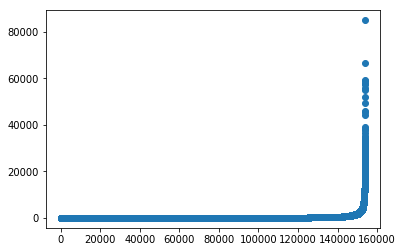

In [22]:
x=np.linspace(0,153979, num=153979)
y=np.sort(views_data_clean.product_id.value_counts())
plt.scatter(x,y)

In [2]:
views_data_clean = pd.read_csv('data/views_data_clean.csv')

In [3]:
transactions_clean = pd.read_csv('data/transactions_clean.csv')

Depois de muitos testes com o sistema de recomendação que vou apresentar a seguir, eu tive que começar a cortar a base para que a matriz usuário-item não ficasse muito esparsa, o que fazia os resultados despencarem. Foram feitos dois tipos de corte:

* Corte pelo número de visualizações
* Corte pelo número de interações

Estes cortes são interessantes, principalmente porque sistemas de recomendação colaborativos sofrem de cold start, ou seja, é difícil recomendar itens a usuários que interagiram pouco com os produtos.

Para realizar o corte pelo número de visualizações, eu vi que a mediana de visualizações dos produtos é 23. Ao utilizar este valor, a matriz continuava muito esparsa. Então eu resolvi ir alterando o número de corte das visualizações de forma que eu não cortasse muito a base de transações. Considerando apenas produtos com mais de 1000 visualizações no período, eu estaria considerando 67.20% da base de transações

In [25]:
np.median(views_data_clean.product_id.value_counts())

23.0

In [4]:
highly_searched_products = (views_data_clean.product_id.value_counts() >= 1000)
highly_searched_products = highly_searched_products[highly_searched_products == True].reset_index()
highly_searched_products = highly_searched_products.rename(columns={'index': 'product_id', 'product_id': 'cond'})

In [5]:
highly_searched_and_purchased = transactions_clean.merge(highly_searched_products, how='inner', on='product_id')
print('{0:.2f}% of the purchases have more than 1000 views'.format((len(highly_searched_and_purchased)/len(transactions_clean))*100))

67.20% of the purchases have more than 1000 views


Para o sistema de recomendação, eu decidi utilizar como interação implícita uma soma de força de eventos. A força de eventos consiste em somar o número de visualizações com o número de compras de um produto em relação a um usuário. 

Entretanto, é muito natural que eu tenha muito mais visualizações do que compra. Dessa forma, para suavizar a força dos eventos de visualização, eu decidi aplicar o logaritmo na base 2 nos valores das somas das visualizações.

In [6]:
highly_searched_and_viewed = views_data_clean.merge(highly_searched_products, how='inner', on='product_id')
highly_searched_and_viewed = highly_searched_and_viewed.groupby(['browser_id','product_id']).count().cond.reset_index()

highly_searched_and_viewed['event_strength'] = np.log(highly_searched_and_viewed.cond+1)
highly_searched_and_viewed = highly_searched_and_viewed.drop('cond',axis=1)

Este gráfico mostra o histograma das forças dos eventos de visualizações, após a aplicação do logaritmo. Podemos verificar que raramente a força de um evento de visualização vai ultrapassar 5, que é a força de um evento de compra.

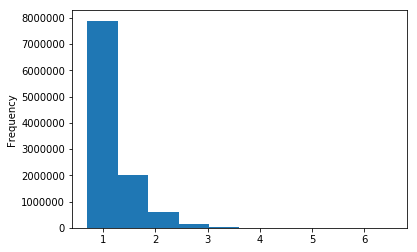

In [39]:
highly_searched_and_viewed.event_strength.plot('hist')

In [7]:
#limpeza para liberar memória
del views_data_clean

Assim como na visualizações, determinei que cada compra é traduzida em uma força do evento, e que quando um usuário realiza uma compra, esse evento tem força 5:

In [8]:
highly_searched_and_purchased = highly_searched_and_purchased.groupby(['browser_id','product_id']).count().cond.reset_index()
highly_searched_and_purchased['event_strength'] = 5
highly_searched_and_purchased = highly_searched_and_purchased.drop(['cond'],axis=1)

Ao unir as duas bases e somar as interações de cada browser_id e produtct_id, eu crio minha base de interações, composta pelo browser_id, product_id e força do evento, pronto para ser utilizado em um sistema de recomendação

In [9]:
interactions_df = highly_searched_and_purchased.append(highly_searched_and_viewed)
interactions_df = interactions_df.groupby(['browser_id','product_id']).sum().reset_index()

In [42]:
interactions_df.head()

,browser_id,product_id,event_strength
0,00000af27a0bb1eed667e6eabdd167fe568ed315,161-0040-001,1.609438
1,00000af27a0bb1eed667e6eabdd167fe568ed315,879-8823-068,0.693147
2,00000af27a0bb1eed667e6eabdd167fe568ed315,879-9017-004,1.098612
3,00000af27a0bb1eed667e6eabdd167fe568ed315,D12-2346-026,0.693147
4,00000af27a0bb1eed667e6eabdd167fe568ed315,D12-2346-788,0.693147


In [10]:
#limpeza para liberar memória
del highly_searched_and_purchased, highly_searched_and_viewed, highly_searched_products

Para finalizar a minha base, eu realizei o segundo corte, que é considerando o número de interações de cada usuário. A mediana neste caso é 3, mas acabei utilizando 8 visualizações como limiar de corte da base, fazendo com que eu reduzisse a minha base inicial de transações para 22.72%.

Eu já tinha percebido faz tempo, mas neste momento em especial eu confirmei para mim mesmo o quanto difícil é criar um sistema de recomendaão que seja aplicado na vida real. Serão muitos produtos (em torno de 80k na minha base), e muitos usuários (2 milhões em apenas dois meses), e a matriz que se cria para um algoritmo comum como o que eu utilizei se torna muito esparsa. Neste momento, eu também fiquei muito interessado em como esses problemas são tratados pela Chaordic. 

Eu imagino que sistemas colaborativos devem passar por cortes na base, assim como eu fiz, mas principalmente deve existir outros sistemas de recomendação, para gerar um sistema híbrido. Como eu não tinha muita informação sobre os produtos ou usuários, acabei não realizando este tipo de sistema. De qualquer forma, deu pra sentir a dificuldade.

In [44]:
np.median(interactions_df.groupby('browser_id').count().product_id)

3.0

In [11]:
highly_interacting_users = (interactions_df.browser_id.value_counts() >= 8)
highly_interacting_users = highly_interacting_users[highly_interacting_users == True].reset_index()
highly_interacting_users = highly_interacting_users.rename(columns={'index': 'browser_id', 'browser_id': 'cond'})


In [27]:
highly_interacting_users_activity = transactions_clean.merge(highly_interacting_users, how='inner', on='browser_id')
print('{0:.2f}% of the transactions are made by users that have more than 8 interactions.'.format((len(highly_interacting_users_activity.browser_id.unique())/len(transactions_clean.browser_id.unique()))*100))

22.72% of the transactions are made by users that have more than 8 interactions.


In [12]:
#limpeza para liberar memória
del transactions_clean

Depois de limpar a base através dos dois cortes (número de visualizações e número de interações), eu verifico que a minha base possui 424k usuários e 7313 itens.

In [54]:
len(highly_interacting_users.browser_id.unique())

424396

In [61]:
len(highly_interacting_users.product_id.unique())

7313

In [13]:
highly_interacting_users = interactions_df.merge(highly_interacting_users, how='inner', on='browser_id').drop(['cond'],axis=1)

In [59]:
highly_interacting_users.head()

,browser_id,product_id,event_strength
0,00000af27a0bb1eed667e6eabdd167fe568ed315,161-0040-001,1.609438
1,00000af27a0bb1eed667e6eabdd167fe568ed315,879-8823-068,0.693147
2,00000af27a0bb1eed667e6eabdd167fe568ed315,879-9017-004,1.098612
3,00000af27a0bb1eed667e6eabdd167fe568ed315,D12-2346-026,0.693147
4,00000af27a0bb1eed667e6eabdd167fe568ed315,D12-2346-788,0.693147


## Sistema de Recomendação

Aqui eu estou destrinchando o meu dataframe para transformá-lo em uma matriz esparsa, definida apenas com os índices do elemento, para salvar memória.

In [14]:
# Get our unique customers
customers = list(np.sort(highly_interacting_users.browser_id.unique())) 

# Get our unique products that were purchased
products = list(highly_interacting_users.product_id.unique()) 

# All of our purchases
quantity = list(highly_interacting_users.event_strength) 

#Find rows and cols in the sparse matrix to create a sparse matrix
rows = highly_interacting_users.browser_id.astype('category', categories = customers).cat.codes 
cols = highly_interacting_users.product_id.astype('category', categories = products).cat.codes 
purchases_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(customers), len(products)))

/home/amenegola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  # This is added back by InteractiveShellApp.init_path()
/home/amenegola/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  if sys.path[0] == '':


Verificando a esparsidade da matriz, obtemos 99.71% de esparsidade. Eu vi em alguns blogs que o ideal é ter uma esparsidade menor que 99.5%. Isso significa que não terei resultados muito bons no sistema de recomendação (mas bem melhores de quando eu não fazia nenhum corte e a esparsidade girava em torno de 99.98%)

In [15]:
matrix_size = purchases_sparse.shape[0]*purchases_sparse.shape[1]
num_purchases = len(purchases_sparse.nonzero()[0]) 
sparsity = 100*(1 - (num_purchases/matrix_size))
sparsity

99.7102248044636

Finalmente, posso separar a minha base em conjuntos de treino e teste. Vou fazer do jeito mais simples, que é mascarar interações no conjunto de treino e ver se essas interações aparecem na recomendação:

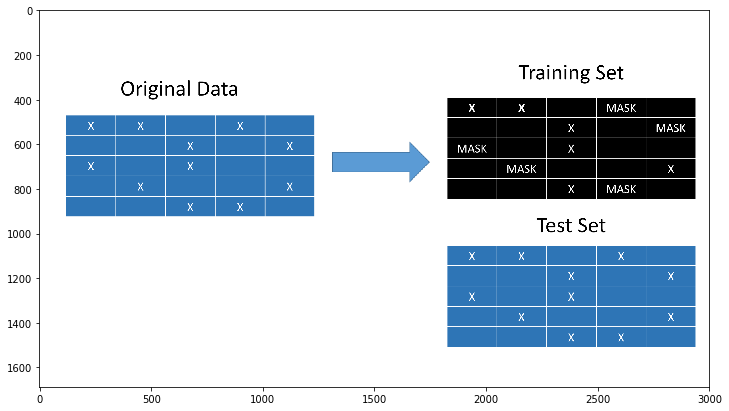

In [39]:
im = Image.open('MaskTrain.png')
plt.figure(figsize=(12,11))
plt.imshow(im)

In [16]:
import random

def make_train(ratings, pct_test = 0.2):
    
    # Make a copy of the original set to be the test set. 
    test_set = ratings.copy() 
    
    # Make a copy of the original data we can alter as our training set. 
    training_set = ratings.copy() 
    
    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero() 
    
    # Zip these pairs together of user,item index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))
    
    # Set the random seed to zero for reproducibility
    random.seed(0)
    
    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs)))
    
    # Sample a random number of user-item pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples) 
    
    # Get the user row indices
    user_inds = [index[0] for index in samples] 
    
    # Get the item column indices
    item_inds = [index[1] for index in samples]
    
    # Assign all of the randomly chosen user-item pairs to zero
    training_set[user_inds, item_inds] = 0
    
    # Get rid of zeros in sparse array storage after update to save space
    training_set.eliminate_zeros()
    
    return training_set, test_set, list(set(user_inds)) 

In [17]:
product_train, product_test, product_users_altered = make_train(purchases_sparse, pct_test = 0.2)

Aqui eu fiz alguns testes para escolher hiperparâmetros. Basicamente, aumentar o valor de alpha, fatores e iterações, e diminuir regularização, aumenta os resultados, mas o que mais impacta é o número de fatores. Com 20 fatores, precision@5 e recall@5 girava em torno de 4~6%, enquanto que aumentando o número de fatores para 400, o resultado aumenta, conforme veremos a seguir.

Eu utilizei a biblioteca que tem o algoritmo ALS para fatorização das matrizes. Sua computação pode ser paralelizada, portanto, mais rápida.

In [42]:
alpha = 60
user_vecs, item_vecs = implicit.alternating_least_squares((product_train*alpha).astype('double'), 
                                                          factors=400, 
                                                          regularization = 0.5, 
                                                          iterations = 100)

This method is deprecated. Please use the AlternatingLeastSquares class instead


Ao todo, em torno de 400k usuários tiveram suas interações alteradas pelo algoritmo que separa os conjuntos de treino e teste. Como eu tenho que multiplicar o vetor de usuário pela de itens, eu resolvi medir as métricas de recall e precision com apenas 50k usuários, para maior velocidade em obter os resultados.

O código abaixo verifica quais interações foram apagadas a partir do conjunto de teste, e mede precision e recall @5 e 10, além de AUC, do modelo colaborativo (CF). Para comparação, eu estou também realizando medições com um modelo de popularidade (Pop), oferecendo os itens mais populares em termos de força de evento como recomendação.

In [ ]:
#iterations = 100
#alpha = 60
#regularization = 0.5
#factors = 400
def auc_score(predictions, test):
    return metrics.roc_auc_score(test, predictions) 

def precision(predicted, actual, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall(predicted, actual, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(actual))
    return result

def process_user(user, training_set, user_vecs_test, item_vecs_test, test_set, pop_items):
    # Get the training set row
    training_row = training_set[user,:].toarray().reshape(-1) 

    # Find where the interaction had not yet occurred
    zero_inds = list(np.where(training_row == 0)[0])
    
    # Get the predicted values based on our user/item vectors
    user_vec = user_vecs_test[user]

    #get prediction for a user
    pred = user_vec.dot(item_vecs_test.T)[zero_inds]
    
    #get reverse sorted indices to put in front the most probable items to recommend
    pred_indices = np.argsort(-pred)
    
    #get the indices of the items that were not seen on test set
    actual_indices = np.nonzero(test_set[user,:].toarray()[0,zero_inds].reshape(-1))[0]
    
    #binarize test_set to calculate AUC
    test_set_auc = test_set.copy()
    test_set_auc[test_set_auc != 0] = 1
    actual_auc = test_set_auc[user,:].toarray()[0,zero_inds].reshape(-1)
    
    # Select the binarized yes/no interaction pairs from the original full data
    # that align with the same pairs in training 
    
    # Get the item popularity for our chosen items
    pop = pop_items[zero_inds] 
    pop_indices = np.argsort(-pop)
    
    #return list with all metrics for each user
    return [auc_score(pred, actual_auc), 
            auc_score(pop, actual_auc), 
            precision(pred_indices, actual_indices, 5), 
            precision(pop_indices, actual_indices, 5), 
            precision(pred_indices, actual_indices, 10), 
            precision(pop_indices, actual_indices, 10), 
            recall(pred_indices, actual_indices, 5), 
            recall(pop_indices, actual_indices, 5), 
            recall(pred_indices, actual_indices, 10), 
            recall(pop_indices, actual_indices, 10)]

def calc_metrics(training_set, altered_users, user_vecs, item_vecs, test_set):
    
    # Get sum of item iteractions to find most popular
    pop_items = np.array(test_set.sum(axis = 0)).reshape(-1) 
    
    #list comprehesion to loop over the test users
    output_metrics = [process_user(user, training_set, user_vecs, item_vecs, test_set, pop_items) for user in altered_users]       
    output_metrics = np.sum(output_metrics,axis=0)/len(altered_users)
    return output_metrics 
            
metrics_out = calc_metrics(product_train, 
                            product_users_altered[:50000], 
                            user_vecs, 
                            item_vecs, 
                            product_test)

print('CF AUC: {0:.2f} / Pop AUC: {1:.2f}'.format(metrics_out[0]*100,metrics_out[1]*100))
print('CF Precision@5: {0:.2f} / Pop Precision@5: {1:.2f}'.format(metrics_out[2]*100,metrics_out[3]*100))
print('CF Precision@10: {0:.2f} / Pop Precision@10: {1:.2f}'.format(metrics_out[4]*100,metrics_out[5]*100))
print('CF Recall@5: {0:.2f} / Pop Recall@5: {1:.2f}'.format(metrics_out[6]*100,metrics_out[7]*100))
print('CF Recall@10: {0:.2f} / Pop Recall@10: {1:.2f}'.format(metrics_out[8]*100,metrics_out[9]*100))

Começando a análise pelo modelo de popularidade, é notável a diferença com o modelo colaborativo. A literatura afirma que modelos de popularidade são ótimos modelos, e às vezes difícil de ser batido. Isso faz sentido, pois é bastante natural oferecer produtos mais vendidos. Eu não consegui investigar mais a fundo este modelo, mas eu tenho duas hipóteses para explicar o baixo resultado. A primeira é que, geralmente, a literatura não trata de uma quantidade tão grande de itens e usuários. Portanto, uma grande massa de usuários pode estar comprando itens não tão populares, impactando no resultado. A outra hipótese é que eu não meço popularidade como número de visualizações ou número de compras, mas sim como força de evento. Como eu estou suavizando a força das visualizações com um logaritmo, isto pode estar impactando no resultado.

Em relação ao modelo colaborativo, nota-se que os valores de precision e recall são razoavelmente baixos, mas tendo em vista a alta esparsidade da matriz, eu não achei tão baixo. Com certeza existe espaço para mais análises dos dados, melhorias no modelo, de forma a aumentar estes valores. 

Particularmente, eu gosto mais da métrica Recall para analisar o desempenho do sistema de recomendação, porque me parece mais natural eu medir quantas recomendações eu acertei de acordo com quantos produtos a pessoa interagiu. Por exemplo, pode ser que uma pessoa tenha um interesse intrínseco por apenas dois produtos. Se eu oferecer 5 recomendações, mesmo que certas do ponto de vista de recomendação, a pessoa continuaria interessada em apenas dois produtos. Por isso, eu vejo a métrica precisão como uma métrica muito pessimista (apesar de achar que pessimismo - considerar sempre o pior caso - é bom na área de machine learning).

Em resumo, o meu sistema acerta pouco na mosca (precisão) mas tem resultados interessantes do ponto de vista de relevância dos produtos recomendados (recall).

## API

Para simular um ponto de início de um sistema que possa ser utilizado em produção, desenvolvi uma API com Flask que recebe um arquivo JSON com as informações de visualização de uma página, que pode ser gerado quando um usuário entra em uma página do cliente, e já retorna os 10 itens mais prováveis de recomendação. 

Abaixo, temos uma arquitetura de referência para aplicações Big Data, e acredito que a Chaordic deva ser estruturada mais ou menos dessa forma. Com o código abaixo, eu obtenho uma pequena visualização do que pode ser as camadas de ingestão de dados (Data Ingestion & Data Collector layers) e armazenamento (Data Storage Layer)

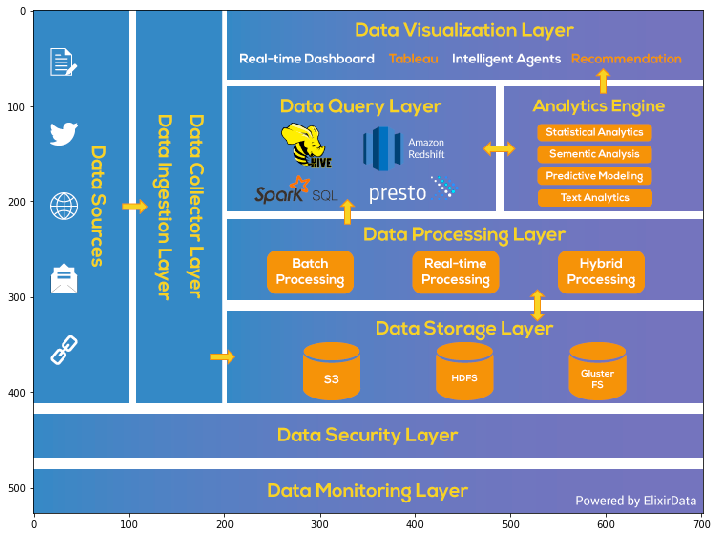

In [49]:
im = Image.open('big-data-framework.png')
plt.figure(figsize=(12,11))
plt.imshow(im)

Como fazer um produto escalar entre os vetores de usuário e itens consome muito tempo, eu primeiro vou salvar as predições do meu modelo no database não relacional MongoDB. Desta forma, durante a execução da API, eu apenas busco as recomendações do meu banco de dados.

O código abaixo salva as predições em um database do MongoDB, além de já criar o arquivo flat com as predições requisitados pelo desafio:

In [52]:
from pymongo import MongoClient

#create MongoDB client
client = MongoClient('mongodb://localhost:27017')

#create database chaordic_data and two collections, 
# one for page view information and other for recommendations
db = client.chaordic_data
user_data = db.user_data
recommendations = db.recommendations

for i in range(product_test.shape[0]):
    # Get the training set row
    test_row = product_test[i,:].toarray().reshape(-1) 
    
    # Find where the interaction had not yet occurred
    zero_inds = list(np.where(test_row == 0)[0]) 
    
    user_vec = user_vecs[i,:]
    pred = user_vec.dot(item_vecs.T)[zero_inds].reshape(-1)
    pred_indices = np.argsort(-pred)[:10] #get first ten suggestions
    
    #create dic for each browser_id
    browser_id = customers[i]
    product_id = []
    for prod_index in pred_indices:
        product_id.append(products[prod_index])
    
    pred_dict = {'browser_id':browser_id,
                 'items': product_id
                }
    
    result = recommendations.insert_one(pred_dict)
    
    with open("flat_file.ndjson", "a") as f:
        f.write(str(pred_dict)+"\n")

Finalmente, podemos definir a API abaixo que coleta o JSON gerado pelo page view, salva essa informação no banco de dados, busca a recomendação para o browser_id em questão, e retorna ao cliente um JSON com um array de itens para serem recomendados:

In [ ]:
from flask import Flask, jsonify, request
from pymongo import MongoClient

client = MongoClient('mongodb://localhost:27017')
db = client.chaordic_data
user_data = db.user_data
recommendations = db.recommendations

app = Flask(__name__)

@app.route('/chaordic_api', methods=['POST'])
def apicall():
    
    #get json input correctly
    try:
        post_data = request.get_json()
    except Exception as e:
        raise e

    if not post_data:
        return(bad_request())
    else:
        #saves page view info inside mongodb database
        result = user_data.insert_one(post_data)
    
        #get user browser_id for recommendation prediction
        browser_id = post_data['browser_id']
        
        #find recommendation that was previously saved on MongoDB
        browser_recomm = db.recommendations.find({'browser_id':browser_id})[0]
        del browser_recomm['_id']
        
        #output response with recommendations
        responses = jsonify(browser_recomm)
        responses.status_code = 200

        return (responses)

#runs api on port 8080
if __name__ == '__main__':
     app.run(port=8080)

Abaixo verificamos a API em funcionamento:

In [57]:
#Setting the headers to send and accept json responses
header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}

#creating page view info
data_json = {'browser_id': '00000af27a0bb1eed667e6eabdd167fe568ed315',
              'price': 949.9,
              'product_id': 'C62-1129-032',
              'source': 'desktop',
              'timestamp': '2017-12-04 21:52:24',
              'user_id': '2e9fd3d80f230b7a8f3f6341f6e889769e14b8f6'}

#running POST on API
resp = requests.post("http://127.0.0.1:8080/chaordic_api", \
                    data = json.dumps(data_json),\
                    headers= header)

In [59]:
resp.json()

{'browser_id': '00000af27a0bb1eed667e6eabdd167fe568ed315',
 'items': ['D12-1301-026',
  'D13-5552-006',
  'D13-9099-044',
  'D12-8998-006',
  'C62-1511-008',
  'D12-3202-026',
  'D12-0135-714',
  'D22-0677-028',
  'E25-0389-016',
  'D18-1156-128']}

# Conclusão

As elaborações acima descrita com certeza não estão em ordem cronológica. Sabemos que, quando estamos em momento de prototipação, diversas hipóteses são testadas *e a maioria não funciona*.

Em linhas gerais, o desafio já foi um enorme aprendizado, pois nunca tive a oportunidade de trabalhar com um dataset real em sistemas de recomendação. Posso nomear algumas dificuldades que enfrentei e que ainda poderia enfrentar:

* A base, por ser grande, deve ser cuidadosamente analisada para que não se exista o desperdício de informações úteis. Eu tentei ao máximo cortar o mínimo possível, mas não estou satisfeito com a base final. Começaria realizando mais análises, para identificar um melhor ponto de corte. Outro fator que pode ajudar a diminuir a esparsidade é eu encontrar um id único para os browser_id e user_id (eu só considerei o browser_id).
* Mesmo que eu realize análises mais extensas, é muito provável que a matriz usuário-item vai continuar muito esparsa. Uma ideia que eu tive é clusterizar usuários parecidos (em termos de preço de produto, por exemplo, mas posso tentar usar também a informação se é browser ou desktop) e gerar não um, mas vários sistemas colaborativos.
* Acredito que, para que se possa obter resultados mais interessantes, é necessário um sistema híbrido. Por exemplo, realizar feature engineering nos produtos e usuários, para verificar a similaridade entre usuários-itens, e multiplicar ou tirar as médias dos scores.
* Não consegui colocar a minha ideia de validação temporal em prática. Isto seria muito interessante, porque montando o problema dessa forma, eu não apenas vou ter um sistema de recomendação, mas um sistema de recomendação com um preditor de compra embutido.
* Não consigo dizer se lidei com os dados de forma correta. Acredito que tenha que estudar mais sobre formas alternativas às que realizei ao tratar os dados. De uma forma ou outra, eu vou ter que estruturar os dados para colocar no meu algoritmo, a pergunta é *quando*.
* Eu poderia ter realizado diversas otimizações, como por exemplo uma busca por melhores hiperparâmetros, outras formas de definir as forças dos eventos, mas acredito que este tipo de coisa não estava no escopo do desafio pelo limite de tempo.
* Para escrever a API, acabei utilizando MongoDB por ser open source, mas como vocês armazenaram os dados no s3 da amazon, imagino que a infra de vocês deve ser toda na AWS. O código que escrevi pode ser adaptado para o DynamoDB.
* A API que eu escrevi não está fazendo quase nada de tratamento de exceções. Eu deveria verificar se os valores e chaves do JSON que recebo são coerentes, se está faltando alguma chave ou valor, e diversas outras melhorias. Eu deveria me preocupar com chamadas simultâneas da API, escalabilidade.
* A infraestrutura necessária para colocar a Chaordic para funcionar deve ser monstruosa (e muito bonita). APIs rodando em computação distribuída, streams de dados para os bancos de dados, todo problema de escalabilidade, fallback, engines de analytics, visualização de dados, segurança... É, de fato, uma aplicação completa muito interessante.